## Experimental notebook for colorbot example using eager mode with Tensorflow

In [1]:
import os
import time
import functools

import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.contrib.eager.python import tfe

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

data_dir = './colordata'


TensorFlow version: 1.7.0
Eager execution: True


### loading data

In [2]:
def parse_line(line):
  """Parse a line from the colors dataset."""

  # Each line of the dataset is comma-separated and formatted as
  #    color_name, r, g, b
  # so `items` is a list [color_name, r, g, b].
  items = tf.string_split([line], ",").values
  rgb = tf.string_to_number(items[1:], out_type=tf.float32) / 255.
  # Represent the color name as a one-hot encoded character sequence.
  color_name = items[0]
  chars = tf.one_hot(tf.decode_raw(color_name, tf.uint8), depth=256)
  # The sequence length is needed by our RNN.
  length = tf.cast(tf.shape(chars)[0], dtype=tf.int64)
  return rgb, chars, length


def load_dataset(data_dir, url, batch_size):
  """Loads the colors data at path into a PaddedDataset."""

  # Downloads data at url into data_dir/basename(url). The dataset has a header
  # row (color_name, r, g, b) followed by comma-separated lines.
  path = tf.keras.utils.get_file(url.split('/')[-1], url, cache_subdir=data_dir)

  # This chain of commands loads our data by:
  #   1. skipping the header; (.skip(1))
  #   2. parsing the subsequent lines; (.map(parse))
  #   3. shuffling the data; (.shuffle(...))
  #   3. grouping the data into padded batches (.padded_batch(...)).
  dataset = tf.data.TextLineDataset(path).skip(1).map(parse_line).shuffle(
      buffer_size=10000).padded_batch(
          batch_size, padded_shapes=([None], [None, None], []))
  return dataset

In [3]:
SOURCE_TRAIN_URL = "https://raw.githubusercontent.com/random-forests/tensorflow-workshop/master/extras/colorbot/data/train.csv"
SOURCE_TEST_URL = "https://raw.githubusercontent.com/random-forests/tensorflow-workshop/master/extras/colorbot/data/test.csv"

batch_size = 64

data_dir = os.path.join(data_dir, "data")
data_dir = os.path.abspath(data_dir)
train_data = load_dataset(
  data_dir=data_dir, url=SOURCE_TRAIN_URL, batch_size=batch_size)
eval_data = load_dataset(
  data_dir=data_dir, url=SOURCE_TEST_URL, batch_size=batch_size)


### The model

In [4]:
class RNNColorbot(tf.keras.Model):
    """Multi-layer (LSTM) RNN that regresses on real-valued vector labels.
    """

    def __init__(self, rnn_cell_sizes, label_dimension, keep_prob):
        """Constructs an RNNColorbot.

        Args:
          rnn_cell_sizes: list of integers denoting the size of each LSTM cell in
            the RNN; rnn_cell_sizes[i] is the size of the i-th layer cell
          label_dimension: the length of the labels on which to regress
          keep_prob: (1 - dropout probability); dropout is applied to the outputs of
            each LSTM layer
        """
        super(RNNColorbot, self).__init__(name="")
        self.label_dimension = label_dimension
        self.keep_prob = keep_prob

        self.cells = self._add_cells(
            [tf.nn.rnn_cell.BasicLSTMCell(size) for size in rnn_cell_sizes])
        self.relu = tf.layers.Dense(
            label_dimension, activation=tf.nn.relu, name="relu")


    def call(self, inputs, training=False):
        """Implements the RNN logic and prediction generation.

        Args:
          inputs: A tuple (chars, sequence_length), where chars is a batch of
            one-hot encoded color names represented as a Tensor with dimensions
            [batch_size, time_steps, 256] and sequence_length holds the length
            of each character sequence (color name) as a Tensor with dimension
            [batch_size].
          training: whether the invocation is happening during training

        Returns:
          A tensor of dimension [batch_size, label_dimension] that is produced by
          passing chars through a multi-layer RNN and applying a ReLU to the final
          hidden state.
        """
        (chars, sequence_length) = inputs
        # Transpose the first and second dimensions so that chars is of shape
        # [time_steps, batch_size, dimension].
        chars = tf.transpose(chars, [1, 0, 2])
        # The outer loop cycles through the layers of the RNN; the inner loop
        # executes the time steps for a particular layer.
        batch_size = int(chars.shape[1])
        for l in range(len(self.cells)):
            cell = self.cells[l]
            outputs = []
            state = cell.zero_state(batch_size, tf.float32)
            # Unstack the inputs to obtain a list of batches, one for each time step.
            chars = tf.unstack(chars, axis=0)
            for ch in chars:
                output, state = cell(ch, state)
                outputs.append(output)
            # The outputs of this layer are the inputs of the subsequent layer.
            chars = tf.stack(outputs, axis=0)
            if training:
                chars = tf.nn.dropout(chars, self.keep_prob)
        # Extract the correct output (i.e., hidden state) for each example. All the
        # character sequences in this batch were padded to the same fixed length so
        # that they could be easily fed through the above RNN loop. The
        # `sequence_length` vector tells us the true lengths of the character
        # sequences, letting us obtain for each sequence the hidden state that was
        # generated by its non-padding characters.
        batch_range = [i for i in range(batch_size)]
        indices = tf.stack([sequence_length - 1, batch_range], axis=1)
        hidden_states = tf.gather_nd(chars, indices)
        return self.relu(hidden_states)

    
    def _add_cells(self, cells):
        # "Magic" required for keras.Model classes to track all the variables in
        # a list of tf.layers.Layer objects.
        # TODO(ashankar): Figure out API so user code doesn't have to do this.
        for i, c in enumerate(cells):
            setattr(self, "cell-%d" % i, c)
        return cells



In [5]:
def train_one_epoch(model, optimizer, train_data, log_interval=10):
    """Trains model on train_data using optimizer."""

    tf.train.get_or_create_global_step()

    def model_loss(labels, chars, sequence_length):
        predictions = model((chars, sequence_length), training=True)
        loss_value = loss(labels, predictions)
        tf.contrib.summary.scalar("loss", loss_value)
        return loss_value

    for (batch, (labels, chars, sequence_length)) in enumerate(
        tfe.Iterator(train_data)):
        with tf.contrib.summary.record_summaries_every_n_global_steps(log_interval):
            batch_model_loss = functools.partial(model_loss, labels, chars,
                                               sequence_length)
            optimizer.minimize(
              batch_model_loss, global_step=tf.train.get_global_step())
            if log_interval and batch % log_interval == 0:
                print("train/batch #%d\tloss: %.6f" % (batch, batch_model_loss()))


def loss(labels, predictions):
    """Computes mean squared loss."""
    return tf.reduce_mean(tf.square(predictions - labels))


def test(model, eval_data):
    """Computes the average loss on eval_data, which should be a Dataset."""
    avg_loss = tfe.metrics.Mean("loss")
    for (labels, chars, sequence_length) in tfe.Iterator(eval_data):
        predictions = model((chars, sequence_length), training=False)
        avg_loss(loss(labels, predictions))
    print("eval/loss: %.6f\n" % avg_loss.result())
    with tf.contrib.summary.always_record_summaries():
        tf.contrib.summary.scalar("loss", avg_loss.result())


### Running the model

In [6]:
# useful params.

use_gpu = False
num_epochs = 60
log_interval = 10

if use_gpu and tfe.num_gpus() > 0:
    device = "/gpu:0"
    print(tfe.num_gpus())
else:
    device = "/cpu:0"
print("Using device %s." % device)

log_dir = os.path.join(data_dir, "summaries")
tf.gfile.MakeDirs(log_dir)

train_summary_writer = tf.contrib.summary.create_file_writer(
  os.path.join(log_dir, "train"), flush_millis=10000)
test_summary_writer = tf.contrib.summary.create_file_writer(
  os.path.join(log_dir, "eval"), flush_millis=10000, name="eval")


model = RNNColorbot(
  rnn_cell_sizes=[256, 128],
  label_dimension=3,
  keep_prob=0.5)

optimizer = tf.train.AdamOptimizer(learning_rate=0.005)


with tf.device(device):
    for epoch in range(num_epochs):
        start = time.time()
        with train_summary_writer.as_default():
            train_one_epoch(model, optimizer, train_data, log_interval)
        end = time.time()
        print("train/time for epoch #%d: %.2f" % (epoch, end - start))
        with test_summary_writer.as_default():
            test(model, eval_data)



Using device /cpu:0.
train/batch #0	loss: 0.195222
train/batch #10	loss: 0.139604
train/time for epoch #0: 3.53
eval/loss: 0.096366

train/batch #0	loss: 0.103895
train/batch #10	loss: 0.102696
train/time for epoch #1: 3.38
eval/loss: 0.087820

train/batch #0	loss: 0.086385
train/batch #10	loss: 0.082124
train/time for epoch #2: 3.42
eval/loss: 0.071092

train/batch #0	loss: 0.078862
train/batch #10	loss: 0.079547
train/time for epoch #3: 3.39
eval/loss: 0.068192

train/batch #0	loss: 0.075266
train/batch #10	loss: 0.069411
train/time for epoch #4: 3.43
eval/loss: 0.069553

train/batch #0	loss: 0.083395
train/batch #10	loss: 0.060095
train/time for epoch #5: 3.26
eval/loss: 0.068354

train/batch #0	loss: 0.069051
train/batch #10	loss: 0.062178
train/time for epoch #6: 3.38
eval/loss: 0.066311

train/batch #0	loss: 0.081664
train/batch #10	loss: 0.081469
train/time for epoch #7: 3.35
eval/loss: 0.063767

train/batch #0	loss: 0.071368
train/batch #10	loss: 0.070541
train/time for epoch #

### Trying the model 

In [7]:
print("Colorbot is ready to generate colors!")
# while True:
#     try:
#         color_name = six.moves.input(
#           "Give me a color name (or press enter to exit): ")
#     except EOFError:
#         return

def check_color(color_name):
    _, chars, length = parse_line(color_name)
    with tf.device(device):
        (chars, length) = (tf.identity(chars), tf.identity(length))
        chars = tf.expand_dims(chars, 0)
        length = tf.expand_dims(length, 0)
        preds = tf.unstack(model((chars, length), training=False)[0])

    # Predictions cannot be negative, as they are generated by a ReLU layer;
    # they may, however, be greater than 1.
    clipped_preds = tuple(min(float(p), 1.0) for p in preds)
    print('predictions:', [float(x) for x in preds])
    rgb = tuple(int(p * 255) for p in clipped_preds)
    print("rgb:", rgb)
    data = [[clipped_preds]]
    plt.imshow(data)
    plt.title(color_name)
    plt.show()


Colorbot is ready to generate colors!


predictions: [0.05765679478645325, 0.2732844054698944, 0.8310462236404419]
rgb: (14, 69, 211)


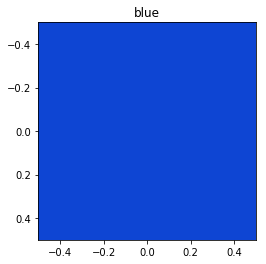

In [17]:
text = 'blue'
check_color(text.lower())
